In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

In [6]:
import data_getter
import outputs_reader
import plot3d

In [7]:
data_folder = "for_visualization_05_02_2025/"
folder_path_outputs = '/app/nse/outputs/' + data_folder
file_path_results = '/app/nse/py_code/results/' + data_folder

In [8]:
x_size = 128
y_size = 128
z_size = 64
x_lenght = 2000
y_width = 2000
z_height = 1000
x_start = 500

## Draw

In [9]:
def normal_dist(x, mean, sd):
    prob_density = 1/(np.sqrt(2*np.pi)*sd) * np.exp(-((x-mean)/(np.sqrt(2)*sd))**2)
    return prob_density

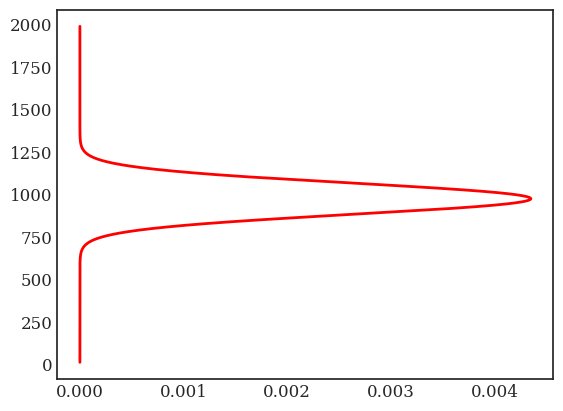

In [20]:
yas = np.arange(10, 1990)
xas = normal_dist(yas, mean, std)
plt.plot(xas, yas, linewidth=2, color='red')
plt.show()

In [58]:
def plot_slice(slice_data, coord_1, coord_2, mean, std, distances, 
                          label_1="x", label_2="y",
                          title="Concentration Map",
                          cutter=0,
                          figsize=(8, 6),
                          cmap='viridis',
                          dpi=300,
                          font_family='serif',
                          font_size=12,
                          colorbar_label='Concentration',
                          output_path=None):
    # Set the style
    plt.style.use('seaborn-v0_8-white')
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    # Create coordinate grids
    grid_1, grid_2 = np.meshgrid(coord_1, coord_2)
    
    # Create the contour plot
    levels = 50
    contour = ax.contourf(grid_1, grid_2, slice_data,
                         levels=levels,
                         cmap=cmap,
                         extend='both')
    y = np.arange(10, 1990)
    print(y.shape)
    x = normal_dist(y, mean, std)
    print()
    ax.plot(x*1e4+distances, y, linewidth=2, color='red', label = "predicted")
    ax.legend()
    # Add a colorbar
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label(colorbar_label, 
                   family=font_family, 
                   size=font_size)
    # Set font properties for all text elements
    plt.rcParams['font.family'] = font_family
    plt.rcParams['font.size'] = font_size
    
    # Set labels and title
    ax.set_xlabel(label_1, family=font_family, size=font_size)
    ax.set_ylabel(label_2, family=font_family, size=font_size)
    ax.set_title(title, family=font_family, size=font_size * 1.2, pad=20)
    
    # Add grid
    # ax.grid(True, linestyle='--', alpha=0.3)
    
    # Make the plot more tight
    plt.tight_layout()
    
    # Save if output path is provided
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=dpi)
    else:
        plt.savefig("slice.png", bbox_inches='tight', dpi=dpi)
    plt.show()

In [42]:
def get_moments_from_1d(slice, coord):
    slice[slice<0]=0
    sl_sum = np.sum(slice)
    if sl_sum != 0:
        slice = np.asarray(slice)/(np.sum(slice))
    mean = np.sum(np.asarray(slice) * np.asarray(coord))
    std_2 = np.sum((np.asarray(coord) - mean) **2 * np.asarray(slice))
    std = np.sqrt(std_2)
    return mean, std

In [41]:
def get_moments_from_2d(slice, coord_1, coord_2):
    slice[slice<0]=0
    slice_2 = np.array([np.sum(s) for s in slice])
    slice_T = np.array(slice).T
    slice_1 = np.array([np.sum(s) for s in slice_T])
    mean_1, std_1 = get_moments_from_1d(slice_1, coord_1)
    mean_2, std_2 = get_moments_from_1d(slice_2, coord_2)
    return mean_1, std_1, mean_2, std_2

In [40]:
def get_moments_from_paths_2d(stat_xy_path, stat_xz_path, xy_files, xz_files):
    global x_size, y_size, z_size, x_start
    dist_list = []
    mean_y_list = []
    std_y_list = []
    mean_z_list = []
    std_z_list = []
    
    for i in range(len(xy_files)):
        data_xy = outputs_reader.read_data(stat_xy_path + xy_files[i])
        
        data_xz = outputs_reader.read_data(stat_xz_path + xz_files[i])
        
        coord_x, coord_y = data_getter.get_coords_from_np(data_xy, 2)
        coord_x, coord_z = data_getter.get_coords_from_np(data_xz, 2)

        data_m_xy = data_getter.get_matrix(data_xy[:, -1], [y_size, x_size]) # y, x
        data_m_xz = data_getter.get_matrix(data_xz[:, -1], [z_size, x_size]) # z, x 
        start_idx = np.where(coord_x > x_start)[0]
        for idx in range(start_idx, len(coord_x)):
            dist_list.append(coord_x[idx] - x_start)
            slice_y = data_getter.get_slice_from_2d(data_m_xy, idx, 2)
            slice_z = data_getter.get_slice_from_2d(data_m_xz, idx, 2)

            mean_y, std_y = get_moments_from_1d(slice_y, coord_y)
            mean_z, std_z = get_moments_from_1d(slice_z, coord_z)
            
            mean_y_list.append(mean_y)
            std_y_list.append(std_y)
            mean_z_list.append(mean_z)
            std_z_list.append(std_z)
    return dist_list, mean_y_list, std_y_list, mean_z_list, std_z_list

In [38]:
def get_moments_from_paths_3d(stat_path, files):
    global x_size, y_size, z_size, x_start
    dist_list = []
    mean_y_list = []
    std_y_list = []
    mean_z_list = []
    std_z_list = []
    
    for i in range(len(files)):
        data = outputs_reader.read_data(stat_path + files[i])
        
        coord_x, coord_y, coord_z = data_getter.get_coords_from_np(data, 3)

        data_m = data_getter.get_matrix(data[:, -1], [z_size, y_size, x_size]) # z, y, x
        start_idx = np.where(coord_x > x_start)[0][0]
        for idx in range(start_idx, len(coord_x)):
            dist_list.append(coord_x[idx] - x_start)
            slice_yz = data_getter.get_slice_from_3d(data_m, idx, "x") # z, y

            mean_y, std_y, mean_z, std_z =get_moments_from_2d(slice_yz, coord_y, coord_z)
            
            mean_y_list.append(mean_y)
            std_y_list.append(std_y)
            mean_z_list.append(mean_z)
            std_z_list.append(std_z)
    return dist_list, mean_y_list, std_y_list, mean_z_list, std_z_list

In [11]:
outputs_folder_names = outputs_reader.get_folder_paths(folder_path_outputs, "output*")

In [12]:
stat3d_path = outputs_folder_names[0] + '/stat-3d/'
stat3d_files = outputs_reader.get_filenames(stat3d_path, r'^C\[\d+\]-avg-\.plt$')
data = outputs_reader.read_data(stat3d_path + stat3d_files[0])

In [26]:
data_3d = data[data[:, 3] > 5]
data_3d[:, 3] = np.log(data_3d[:, 3])

In [ ]:
fig = plot3d.plot_3d_scalar(data_3d, x_lenght, y_width, z_height)
fig.show()

In [10]:
fig.write_html("3d_mean_plot.html")

In [13]:
matrix_data = data_getter.get_matrix(data[:, 3], [z_size, y_size, x_size])
coord_x, coord_y, coord_z = data_getter.get_coords_from_np(data, 3)

In [14]:
matrix_data[matrix_data <= 0] = 0.0001
matrix_data = np.log(matrix_data)
matrix_data[matrix_data <= 0] = 0

In [63]:
mean = 552.2141448920027 #973.62208783
std = 109.00482280780436 #91.71344392
distances = 1554.6875

(1980,)



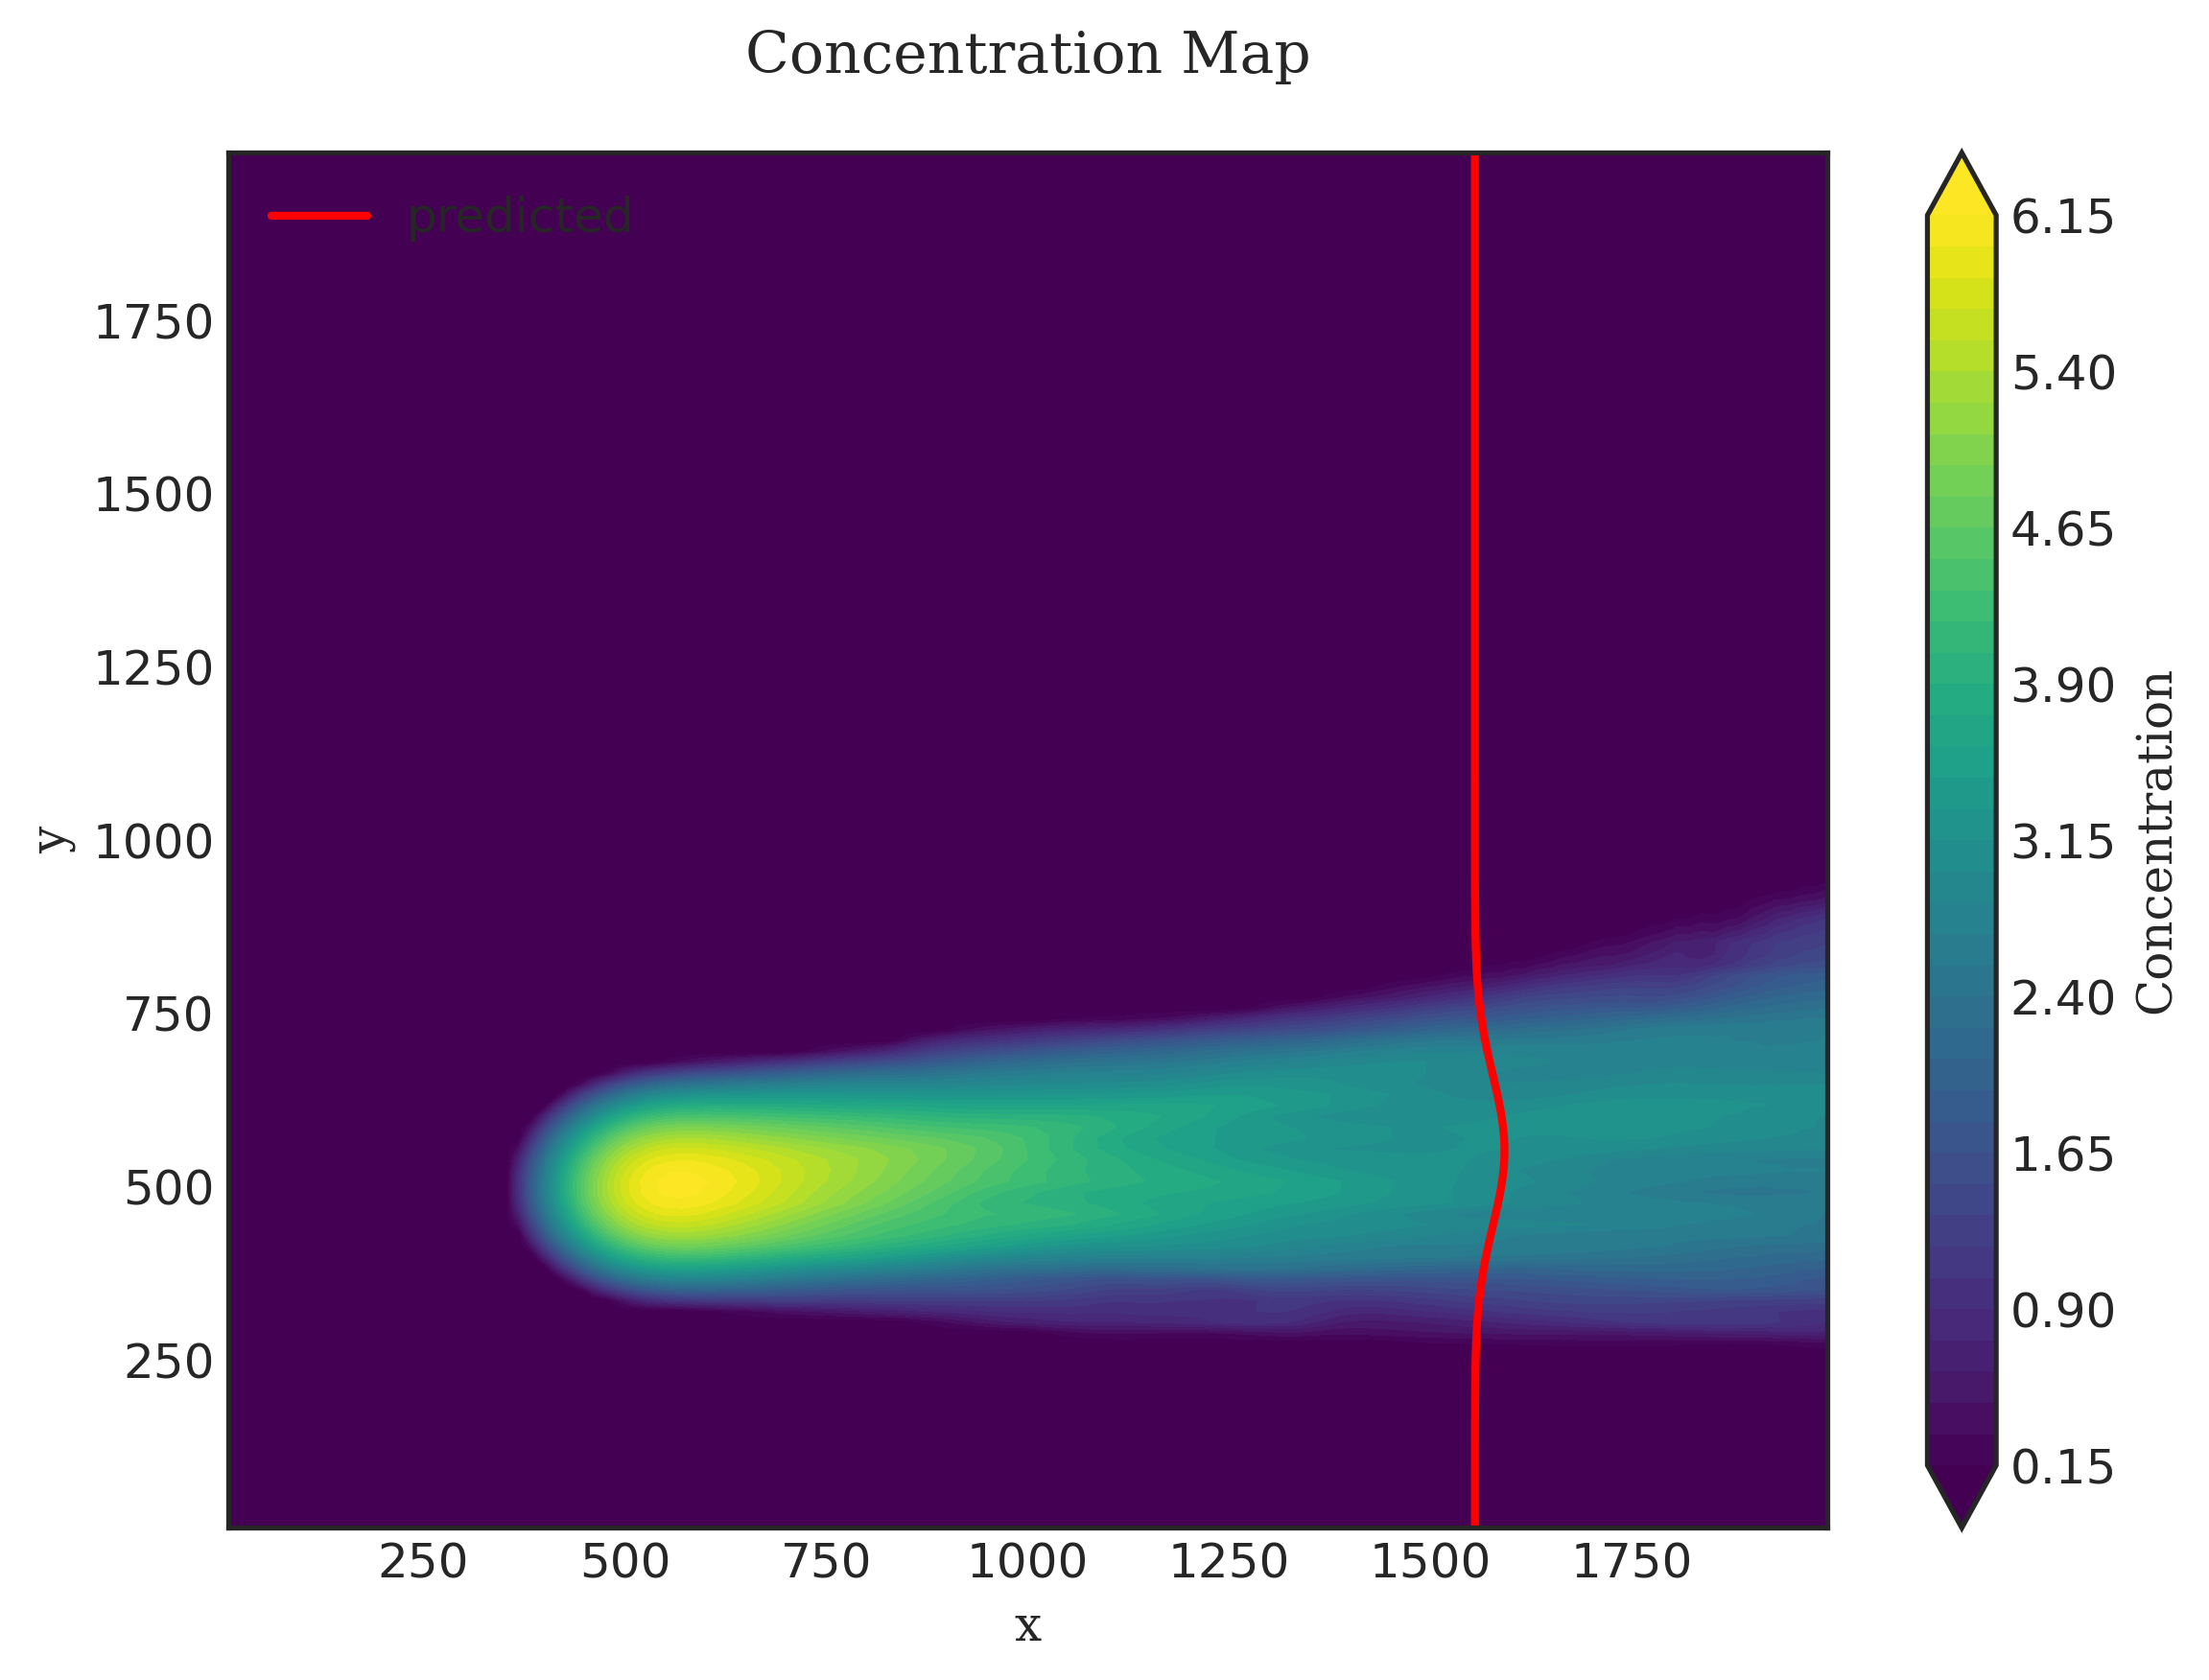

In [64]:
plot_slice(matrix_data[10, :, :], coord_x, coord_y, mean, std, distances)

In [43]:
dist_list, mean_y_list, std_y_list, mean_z_list, std_z_list = get_moments_from_paths_3d(stat3d_path, stat3d_files)

In [60]:
print(dist_list[100-33])

1054.6875
